In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [118]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [119]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [120]:
X, y = df.drop(columns=['median_house_value', 'ocean_proximity', 'total_bedrooms']).values, df['median_house_value'].values
X.shape

(20640, 7)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [122]:
X_test[:,-1]

array([6.    , 2.3079, 2.2898, ..., 6.4978, 3.3056, 3.183 ])

In [123]:
def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std, std, mean

In [124]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train_norm, mean_train, std_train = normalize(X_train_tensor)
X_train_norm = X_train_norm.to(device)
X_test_norm = ((X_test_tensor - mean_train) / std_train).to(device)

y_train_norm, mean, std = normalize(y_train_tensor)
y_train_norm = y_train_norm.to(device)


In [125]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.2):
        super(MLPWithDropout, self).__init__()
        
        hidden_dims = [input_dim] + hidden_dims

        self.layers = nn.ModuleList()
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Sequential(
            nn.Linear(hidden_dims[i-1], hidden_dims[i]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)))

        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)
    
model = MLPWithDropout(7, [7, 10, 2], 1).to(device)


In [126]:
# Paramètres
batch_size = 256
epochs = 200
learning_rate = 0.1
patience = 100 # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')  # Initialiser la meilleure perte de validation à l'infini
early_stop_counter = 0  # Compteur pour suivre le nombre d'époques sans amélioration


# DataLoader pour gérer les batches
train_dataset = TensorDataset(X_train_norm, y_train_norm)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model.train()  # Mode entraînement

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()  # Régression -> Mean Squared Error
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Boucle d'entraînement avec early stopping
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        
        # Déplacer les données sur le même périphérique que le modèle
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Remise à zéro des gradients
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_batch)
        
        # Calcul de la perte
        loss = criterion(y_pred, y_batch)

        # Backward pass et optimisation
        loss.backward()
        optimizer.step()

        # Accumuler la perte
        epoch_loss += loss.item()

    # Calcul de la perte moyenne pour cette époque
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
    
    # Early stopping
    if avg_epoch_loss < best_val_loss:
        best_val_loss = avg_epoch_loss
        early_stop_counter = 0  # Réinitialiser le compteur d'amélioration
    else:
        early_stop_counter += 1

    # Vérifier si le critère de patience est atteint
    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}.")
        break


Epoch 1/200, Loss: 1.0155


/users/eleves-b/2024/ahmed.khairaldin/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/users/eleves-b/2024/ahmed.khairaldin/.local/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/200, Loss: 1.0040
Epoch 3/200, Loss: 1.0017
Epoch 4/200, Loss: 1.0050
Epoch 5/200, Loss: 1.0033
Epoch 6/200, Loss: 1.0029
Epoch 7/200, Loss: 1.0026
Epoch 8/200, Loss: 1.0018
Epoch 9/200, Loss: 1.0021
Epoch 10/200, Loss: 1.0011
Epoch 11/200, Loss: 1.0023
Epoch 12/200, Loss: 1.0018
Epoch 13/200, Loss: 1.0042
Epoch 14/200, Loss: 1.0043
Epoch 15/200, Loss: 1.0041
Epoch 16/200, Loss: 1.0032
Epoch 17/200, Loss: 1.0015
Epoch 18/200, Loss: 1.0010
Epoch 19/200, Loss: 1.0035
Epoch 20/200, Loss: 1.0025
Epoch 21/200, Loss: 1.0052
Epoch 22/200, Loss: 1.0009
Epoch 23/200, Loss: 1.0022
Epoch 24/200, Loss: 1.0052
Epoch 25/200, Loss: 1.0040
Epoch 26/200, Loss: 1.0008
Epoch 27/200, Loss: 1.0030
Epoch 28/200, Loss: 1.0039
Epoch 29/200, Loss: 1.0067
Epoch 30/200, Loss: 1.0023
Epoch 31/200, Loss: 1.0032
Epoch 32/200, Loss: 1.0030
Epoch 33/200, Loss: 1.0009
Epoch 34/200, Loss: 1.0028
Epoch 35/200, Loss: 1.0015
Epoch 36/200, Loss: 1.0023
Epoch 37/200, Loss: 1.0025
Epoch 38/200, Loss: 0.9988
Epoch 39/

In [129]:
y_train.mean(), y_test.mean()

(np.float64(206776.63341812015), np.float64(207172.55087209304))

Ajustement des poids pour la couche layers.0.0.weight
Ajustement des poids pour la couche layers.1.0.weight
Ajustement des poids pour la couche layers.2.0.weight
Ajustement des poids pour la couche output_layer.weight


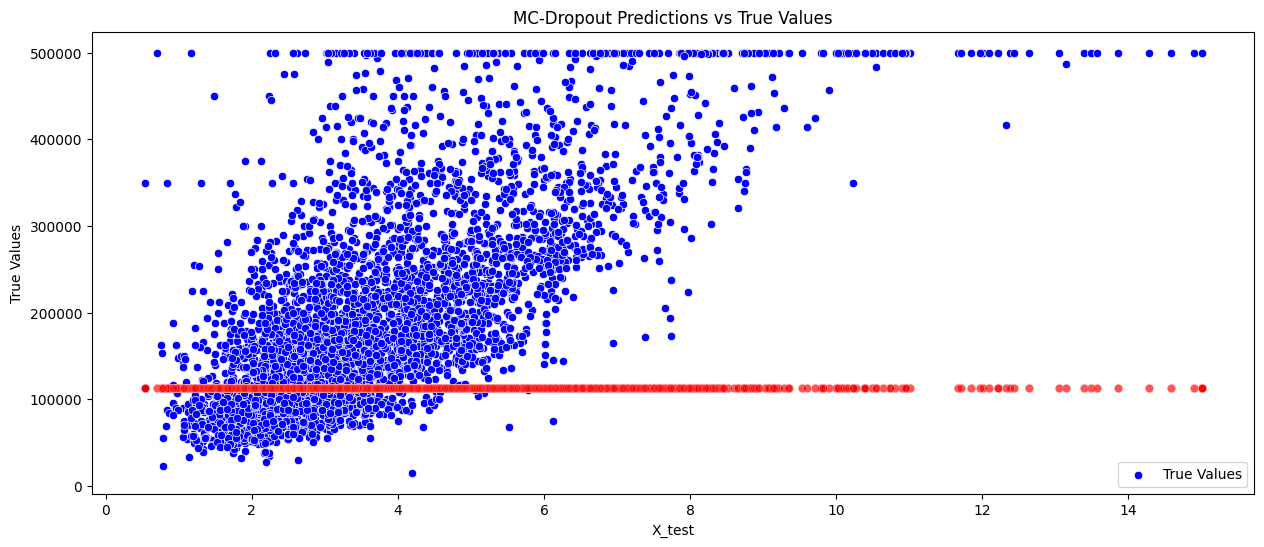

In [128]:

# Créer un tenseur pour X_test_norm (normalisé)
with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:  # On ajuste uniquement les poids, pas les biais
                param.data *= 1 / 0.2
                print(f"Ajustement des poids pour la couche {name}")


# Effectuer des prédictions avec MC-Dropout
y_pred_stack = np.stack([(model(X_test_norm)*std + mean).cpu().detach().numpy() for _ in range(10)])

# Créer un DataFrame avec les vraies valeurs
predictions_df = pd.DataFrame({
    'X_test': X_test[:,-1],
    'True Values': y_test
})

# Ajouter les prédictions dans le DataFrame de manière dynamique
for i in range(10):
    predictions_df[f'Prediction {i+1}'] = y_pred_stack[i].flatten()




# Création du graphique
plt.figure(figsize=(15, 6))

# Tracer les vraies valeurs
sns.scatterplot(x='X_test', y='True Values', data=predictions_df, color='blue', label='True Values')

# Tracer toutes les prédictions avec transparence
for i in range(1, 11):
    sns.scatterplot(x='X_test', y=f'Prediction {i}', data=predictions_df, color='red', alpha=0.1)

# Ajouter un titre et une légende
plt.title('MC-Dropout Predictions vs True Values')
plt.legend()

# Afficher le graphique
plt.show()
